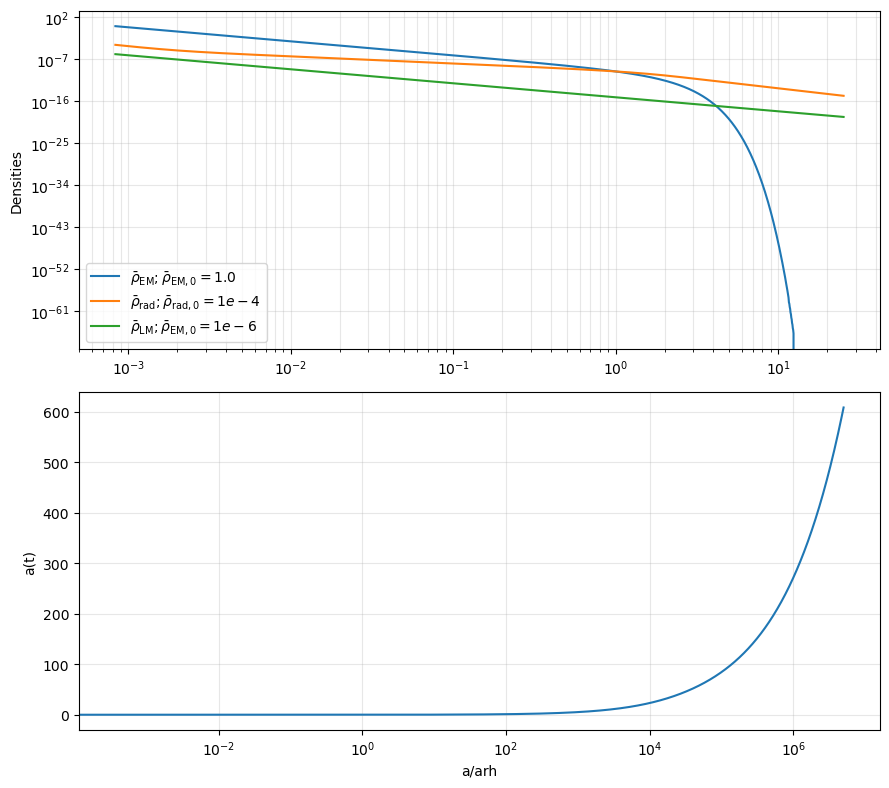

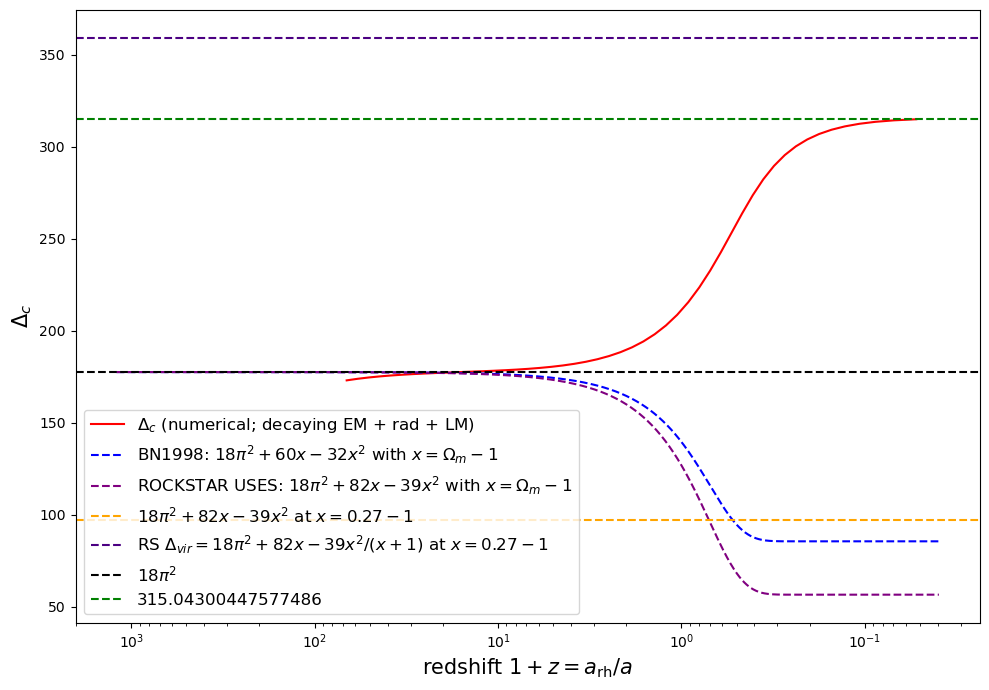

In [5]:
import numpy as np
from math import sqrt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import matplotlib.pyplot as plt


def crossings_from_solution(sol, n_scan=2000):
    tmin, tmax = sol.t[0], sol.t[-1]
    # avoid log10(0)
    ts = np.logspace(np.log10(tmin + 1e-30), np.log10(tmax), n_scan)
    em_s  = sol.sol(ts)[1]
    rad_s = sol.sol(ts)[2]
    g = em_s - rad_s

    roots = []
    for i in range(len(ts) - 1):
        if np.isnan(g[i]) or np.isnan(g[i+1]):
            continue
        if g[i] == 0.0:
            roots.append(ts[i])
            continue
        if g[i] * g[i+1] < 0.0:
            r = brentq(lambda tt: sol.sol(tt)[1] - sol.sol(tt)[2], ts[i], ts[i+1], maxiter=100)
            roots.append(r)
    return np.array(roots)





G = 1.0
TAU = 1.0e4

def rhs_bg(t, y):
    a, rho_em, rho_rad, rho_lm = y
    rho_em  = max(rho_em,  0.0)
    rho_rad = max(rho_rad, 0.0)
    rho_lm  = max(rho_lm,  0.0)
    rho_tot = rho_em + rho_rad + rho_lm
    H2 = (8.0 * np.pi * G / 3.0) * max(rho_tot, 0.0)
    H  = sqrt(H2)
    da_dt   = a * H
    dem_dt  = -rho_em / TAU - 3.0 * H * rho_em
    drad_dt = rho_em / TAU - 4.0 * H * rho_rad
    dlm_dt  = -3.0 * H * rho_lm
    return [da_dt, dem_dt, drad_dt, dlm_dt]


def stall_a(t,y):
    return y[0]
stall_a.terminal = False
stall_a.direction =0


# initial conditions
t0, tf   = 0.0, 5.0e6 # was 5e5
#a0       = 1.0e-6
a0 = 0.02
rho_em0  = 1.0
rho_rad0 = 1.0e-4
rho_lm0  = 1.0e-6

# frac from CONCEPT simulation:
# rho_em0  = 0.999
# rho_lm0  = 1-rho_em0
# rho_rad0 = 1.0e-4

y0_bg    = [a0, rho_em0, rho_rad0, rho_lm0]

sol_bg = solve_ivp(
    rhs_bg, (t0, tf), y0_bg,
    method="Radau", rtol=1e-10, atol=1e-12,
    dense_output=True, events=[stall_a])

t   = sol_bg.t
a   = sol_bg.y[0]
em  = sol_bg.y[1]
rad = sol_bg.y[2]
lm  = sol_bg.y[3]

rho_tot = em + rad + lm
H       = np.sqrt((8.0 * np.pi * G / 3.0) * rho_tot)
rho_c   = 3.0 * H**2 / (8.0 * np.pi * G)  


a_of_t   = interp1d(t, a,   kind='cubic', bounds_error=False, fill_value='extrapolate')
H_of_t   = interp1d(t, H,   kind='cubic', bounds_error=False, fill_value='extrapolate')
em_of_t  = interp1d(t, em,  kind='cubic', bounds_error=False, fill_value='extrapolate')
rad_of_t = interp1d(t, rad, kind='cubic', bounds_error=False, fill_value='extrapolate')
lm_of_t  = interp1d(t, lm,  kind='cubic', bounds_error=False, fill_value='extrapolate')
rho_c_of_t = interp1d(t, rho_c, kind='cubic', bounds_error=False, fill_value='extrapolate')


t_cross = crossings_from_solution(sol_bg)
if len(t_cross) > 0:
    trh = t_cross[0]
    a_rh = float(a_of_t(trh))
z_bg = a_rh / a - 1.0


# plots of bkg densitiies
fig, axs = plt.subplots(2, 1, figsize=(9, 8), sharex=False)

axs[0].loglog(a/a_rh, em, label=r'$\bar\rho_{\rm EM}; \bar\rho_{\rm EM, 0}=1.0$')
axs[0].loglog(a/a_rh, rad, label=r'$\bar\rho_{\rm rad}; \bar\rho_{\rm rad, 0}=1e-4$')
axs[0].loglog(a/a_rh, lm, label=r'$\bar\rho_{\rm LM}; \bar\rho_{\rm EM, 0}=1e-6$')
axs[0].set_ylabel('Densities')
axs[0].legend(); axs[0].grid(True, which='both', alpha=0.3)
axs[1].semilogx(t, a)
axs[1].set_xlabel('a/arh'); axs[1].set_ylabel('a(t)')
axs[1].grid(True, which='both', alpha=0.3)
plt.tight_layout(); plt.show()


def rhs_tophat(t, y, M):
    """ d^2R/dt^2 = -G*M / R^2  (constant M) """
    R, V = y
    R = max(R, 1e-40)
    return [V, -G * M / (R**2)]

# early starting points old
# i0   = 10
# t_i  = t[i0]
# a_i  = float(a_of_t(t_i))
# H_i  = float(H_of_t(t_i))
# rho_m_i = float(em_of_t(t_i) + lm_of_t(t_i))   # "clustering matter" = EM + LM

# iterate over several different small initial overdensities possibilities
# delta_grid = np.logspace(-5, -2, 40)

# early starting points new
i0   = 1 # was 2                 
t_i  = t[i0]
a_i  = float(a_of_t(t_i))
H_i  = float(H_of_t(t_i))
rho_m_i = float(em_of_t(t_i) + lm_of_t(t_i))
delta_grid = np.logspace(-6, -1, 80)
zvir_list = []
Delta_crit_ratio_list = []   #using crit density not vir, this is ρ_tophat / ρ_crit at t_virialization

for d0 in delta_grid:
    # assuming linear ICs at early times
    r_com = 1.0
    R_i = a_i * r_com * (1.0 - d0/3.0)
    V_i = H_i * R_i * (1.0 - d0/3.0)

    # mass 
    M = (4.0/3.0) * np.pi * (R_i**3) * rho_m_i * (1.0 + d0)

    #turnaround V = 0 (going from expansion to contraction)
    def ev_turn(tt, yy):
        return yy[1]
    ev_turn.terminal  = True
    ev_turn.direction = -1

    sol_th = solve_ivp(
        lambda tt, yy: rhs_tophat(tt, yy, M),
        (t_i, tf), [R_i, V_i],
        method='Radau', rtol=1e-10, atol=1e-12,
        dense_output=True, events=ev_turn
    )

    if len(sol_th.t_events[0]) == 0:
        continue

    t_max = sol_th.t_events[0][0]
    R_max = sol_th.sol(t_max)[0]

    t_vir = 2.0 * t_max
    R_vir = 0.5 * R_max

    #make sure it covers tvir
    if not (t[0] <= t_vir <= t[-1]):
        continue


    # densities at virialization
    rho_th_vir = (3.0 * M) / (4.0 * np.pi * R_vir**3)  # avg tophat density
    rho_c_vir  = float(rho_c_of_t(t_vir))              # crit density 
    
    a_vir = float(a_of_t(t_vir))
    z_vir = a_rh / a_vir - 1.0
    zvir_list.append(z_vir)
    Delta_crit_ratio_list.append(rho_th_vir / rho_c_vir)

zvir  = np.array(zvir_list)
Delta_crit_ratio_num = np.array(Delta_crit_ratio_list)


Omega_m_bg = (em + lm) / (em + lm + rad)
x_bg       = Omega_m_bg - 1.0
Delta_crit_BN = 18.0 * np.pi**2 + 60.0 * x_bg - 32.0 * x_bg**2
Delta_crit_BN2 = 18*np.pi**2 + 82*x_bg - 39*x_bg**2

x2 = 0.27-1
Delta_crit_BN_LCDM = (18*np.pi**2 + 82*x2 - 39*x2**2)
Delta_vir_BN_LCDM = (18*np.pi**2 + 82*x2 - 39*x2**2)/(x2+1)


# plots!
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(1+zvir, Delta_crit_ratio_num, color='r',
           label=r'$\Delta_{c}$ (numerical; decaying EM + rad + LM)')

ax.plot(1+z_bg, Delta_crit_BN, 'b--',
        label=r'BN1998: $18\pi^{2}+60x-32x^{2}$ with $x=\Omega_{m}-1$')


ax.plot(1+z_bg, Delta_crit_BN2, 'purple', linestyle='--',
        label=r'ROCKSTAR USES: $18\pi^{2}+82x-39x^{2}$ with $x=\Omega_{m}-1$')

ax.axhline(Delta_crit_BN_LCDM, color= 'orange', linestyle='--',
        label=r'$18\pi^{2}+82x-39x^{2}$ at $x=0.27-1$')


ax.axhline(Delta_vir_BN_LCDM, color= 'indigo', linestyle='--',
        label=r'RS $\Delta_{vir} = 18\pi^{2}+82x-39x^{2}/(x+1)$ at $x=0.27-1$')


ax.axhline(18.0 * np.pi**2, color='k', linestyle='--',
           label=r'$18\pi^{2}$')

ax.set_xscale('log')
ax.invert_xaxis()

ax.set_xlabel(r'redshift $1+z = a_{\rm rh}/a$', fontsize=15)
ax.set_ylabel(r'$\Delta_{c}$', fontsize=15)
ax.axhline(np.max( Delta_crit_ratio_num), color='g', linestyle='--',label=f'{np.max( Delta_crit_ratio_num)}')


ax.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

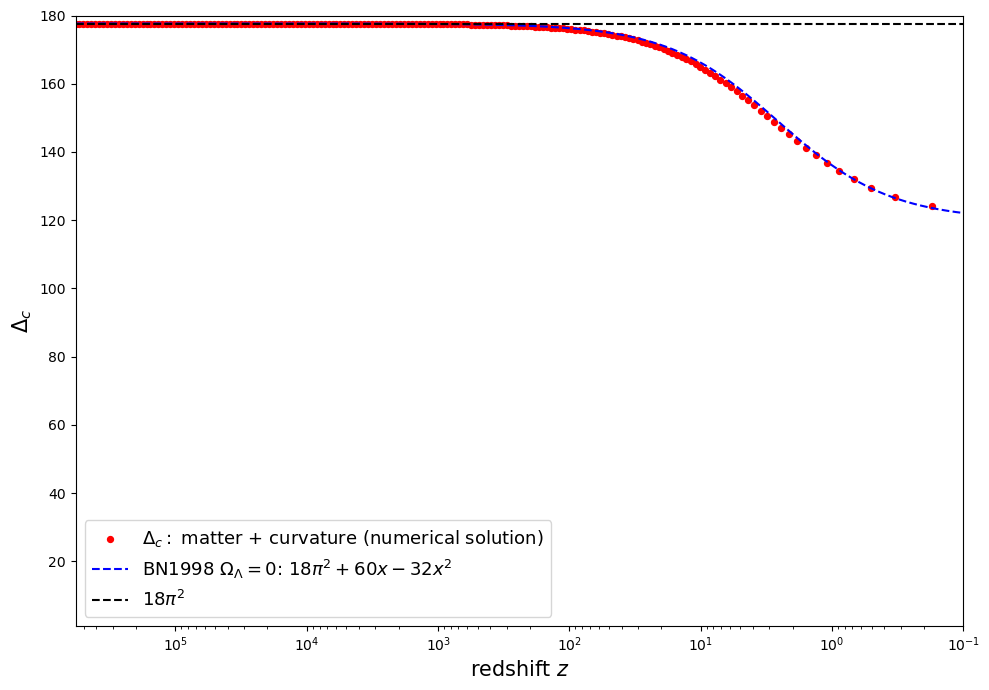

In [3]:
# Matter + Curvature Case 

G = 1.0
Omega_m0 = 0.3
Omega_k0 = 1.0 - Omega_m0
# Omega_k0 = .5
# Omega_m0 = 1 - Omega_k0
H0 = 1.0
rho_crit0 = 3*H0**2 / (8*np.pi*G)
rho_m0 = Omega_m0 * rho_crit0
rho_k0 = Omega_k0 * rho_crit0


def H_of_a(a):
    return H0 * np.sqrt(Omega_m0 * a**-3 + Omega_k0 * a**-2)

def Omega_m_of_a(a):
    Em2 = Omega_m0 * a**-3 + Omega_k0 * a**-2
    return (Omega_m0 * a**-3) / Em2

def rhs_bg(t, y):
    a, rho_m, rho_k = y
    a = max(a, 1e-40)
    rho_m = max(rho_m, 0.0)
    rho_k = max(rho_k, 0.0)
    H = H_of_a(a)
    return [a*H, -3*H*rho_m, -2.*H*rho_k]

#integrate background
a_init = 1e-8
y0_bg  = [a_init, rho_m0 * a_init**-3, rho_k0*a_init**-2] 
t0, tf = 0.0, 8.0e4 
sol_bg = solve_ivp(rhs_bg, (t0, tf), y0_bg, method='Radau', rtol=1e-10, atol=1e-12, dense_output=True)
t      = sol_bg.t
a      = sol_bg.y[0]
rho_m  = sol_bg.y[1]
rho_k  = sol_bg.y[2]
H      = H_of_a(a)
rho_c  = 3 * H**2 / (8 * np.pi * G)

#interpolators
a_of_t = interp1d(t, a, kind='cubic', bounds_error=False, fill_value='extrapolate')
t_of_a = interp1d(a, t, kind='cubic', bounds_error=False, fill_value='extrapolate')
H_of_t = interp1d(t, H,kind='cubic', bounds_error=False, fill_value='extrapolate')
rho_m_of_t = interp1d(t,rho_m, kind='cubic', bounds_error=False, fill_value='extrapolate')
rho_c_of_t = interp1d(t,rho_c, kind='cubic', bounds_error=False, fill_value='extrapolate')


def rhs_tophat(t, y, M):
    """ d^2R/dt^2 = -GM/R^2 """
    R, V = y
    R = max(R, 1e-40)
    return [V, -G*M/(R**2)]

i0       = 10  
t_i      = t[i0]
a_i      = float(a_of_t(t_i))
H_i      = float(H_of_t(t_i))
rho_m_i  = float(rho_m_of_t(t_i))

#delta_grid = np.logspace(-5, -2, 40)
delta_grid = np.logspace(-8, -2, 200)
zvir_list = []
delta_crit_ratio_list = []  #ρ_tophat/ρ_crit at virialization
for d0 in delta_grid:
    r_com = 1.0
    R_i = a_i * r_com * (1.0 - d0/3.0)
    V_i = H_i * R_i * (1.0 - d0/3.0)
    M   = (4.0/3.0) * np.pi * (R_i**3) * rho_m_i * (1.0 + d0)
    # Turnaround event: V = 0 
    def ev_turn(tt, yy):
        return yy[1]
    ev_turn.terminal  = True
    ev_turn.direction = -1
    sol1 = solve_ivp(lambda tt, yy: rhs_tophat(tt, yy, M), (t_i, tf), [R_i, V_i], method='Radau',
        rtol=1e-10, atol=1e-12, dense_output=True, events=ev_turn)
    if len(sol1.t_events[0]) == 0:
        # turnaround not reached in time..?, just move on 
        continue

    #assume tvir=2tmax!
    t_max = sol1.t_events[0][0]
    R_max = sol1.sol(t_max)[0]
    t_vir = 2.0 * t_max
    R_vir = 0.5 * R_max

    # make sure bkg actually hits t_vir else trash
    if not (t[0] <= t_vir <= t[-1]):
        continue

    # densities 
    rho_th_vir = (3.0*M)/(4*np.pi*R_vir**3)  #tophat density
    rho_c_vir  = float(rho_c_of_t(t_vir))              #crit density
    a_vir = float(a_of_t(t_vir))
    z_vir = 1.0 / a_vir - 1.0
    zvir_list.append(z_vir)
    delta_crit_ratio_list.append(rho_th_vir / rho_c_vir)

zvir  = np.array(zvir_list)
Delta_crit_ratio_num = np.array(delta_crit_ratio_list)  


def bn98(a):
    Om = Omega_m_of_a(a)
    x  = Om - 1.0
    return 18.0 * np.pi**2 + 60.0 * x - 32.0 * x**2 

a_vir_vals = 1.0 / (1.0 + zvir)
Delta_crit_ratio_BN = bn98(a_vir_vals)

# plot

Om = rho_m/rho_c
x  = Om - 1.0
f = 18.0 * np.pi**2 + 60.0 * x - 32.0 * x**2

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(zvir, Delta_crit_ratio_num,color='r', s=18,label=r'$\Delta_{c}:$ matter + curvature (numerical solution)') 
ax.plot(1.0/a - 1, f, color='b',linestyle='--',label=r'BN1998 $\Omega_{\Lambda}=0$: $18\pi^{2}+60x-32x^{2}$')

ax.set_xscale('log')
ax.invert_xaxis()
ax.set_ylim(1,180)
ax.set_xlim(np.max(zvir)+100,1e-1)
ax.set_xlabel('redshift $z$', fontsize=15)
ax.set_ylabel(r'$\Delta_{c}$', fontsize=15)
plt.axhline(y=18*np.pi**2,color='k', linestyle='--',label=r'$18\pi^{2}$')
ax.legend(loc='best',fontsize=13)
plt.tight_layout()
plt.show()
